In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import missingno as msno
import pandas_profiling
import sklearn
import scipy

sns.set_context("poster", font_scale=1.3)
import folium
import ipywidgets as widgets

% matplotlib inline
% config InlineBackend.figure_format='retina'


In [3]:
mpl_update = {'font.size': 16,
              'xtick.labelsize': 14,
              'ytick.labelsize': 14,
              'figure.figsize': [12.0, 8.0],
              'axes.color_cycle': ['#0055A7', '#2C3E4F', '#26C5ED', '#00cc66', '#D34100', '#FF9700', '#091D32'],
              'axes.labelsize': 16,
              'axes.labelcolor': '#677385',
              'axes.titlesize': 20,
              'lines.color': '#0055A7',
              'lines.linewidth': 3,
              'text.color': '#677385'}
mpl.rcParams.update(mpl_update)


D:\Coding\Anaconda3\envs\idata\lib\site-packages\matplotlib\__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


In [5]:
def time_slice(df, time_period):
    # Only take data for time period of interest
    df = df[df.time_period == time_period]

    # Pivot table 
    df = df.pivot(index='country', columns='variable', values='value')

    df.columns.name = time_period

    return df

def country_slice(df, country):
    # Only take data for country of interest
    df = df[df.country == country]

    # Pivot table 
    df = df.pivot(index='variable', columns='time_period', values='value')

    df.index.name = country
    return df

def variable_slice(df, variable):
    # Only data for that variable
    df = df[df.variable == variable]

    # Get variable for each country over the time periods 
    df = df.pivot(index='country', columns='time_period', values='value')
    return df


def time_series(df, country, variable):
    # Only take data for country/variable combo 
    series = df[(df.country == country) & (df.variable == variable)]

    # Drop years with no data 
    series = series.dropna()[['year_measured', 'value']]

    # Change years to int and set as index 
    series.year_measured = series.year_measured.astype(int)
    series.set_index('year_measured', inplace=True)
    series.columns = [variable]
    return series

def subregion(data, region):
    return data[data.region == region]

simple_regions = {
    'World | Asia': 'Asia',
    'Americas | Central America and Caribbean | Central America': 'North America',
    'Americas | Central America and Caribbean | Greater Antilles': 'North America',
    'Americas | Central America and Caribbean | Lesser Antilles and Bahamas': 'North America',
    'Americas | Northern America | Northern America': 'North America',
    'Americas | Northern America | Mexico': 'North America',
    'Americas | Southern America | Guyana': 'South America',
    'Americas | Southern America | Andean': 'South America',
    'Americas | Southern America | Brazil': 'South America',
    'Americas | Southern America | Southern America': 'South America',
    'World | Africa': 'Africa',
    'World | Europe': 'Europe',
    'World | Oceania': 'Oceania'
}


In [6]:
mpl_update = {'font.size': 16,
              'xtick.labelsize': 14,
              'ytick.labelsize': 14,
              'figure.figsize': [12.0, 8.0],
              'axes.color_cycle': ['#0055A7', '#2C3E4F', '#26C5ED', '#00cc66', '#D34100', '#FF9700', '#091D32'],
              'axes.labelsize': 16,
              'axes.labelcolor': '#677385',
              'axes.titlesize': 20,
              'lines.color': '#0055A7',
              'lines.linewidth': 3,
              'text.color': '#677385'}
mpl.rcParams.update(mpl_update)


D:\Coding\Anaconda3\envs\idata\lib\site-packages\matplotlib\__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


In [9]:
data = pd.read_csv("E:\Workspace\jupyter_notebook\\notebook_idata_lesson01\Aquastat\data\\aquastat.csv.gzip"
                   , compression="gzip")

data.region = data.region.apply(lambda x: simple_regions[x])

data = data.loc[~data.variable.str.contains('exploitable'), :]
data = data.loc[~(data.variable == 'national_rainfall_index')]

recent = time_slice(data, '2013-2017')


Text(0,0.5,'GDP per capita ($USD/person)')

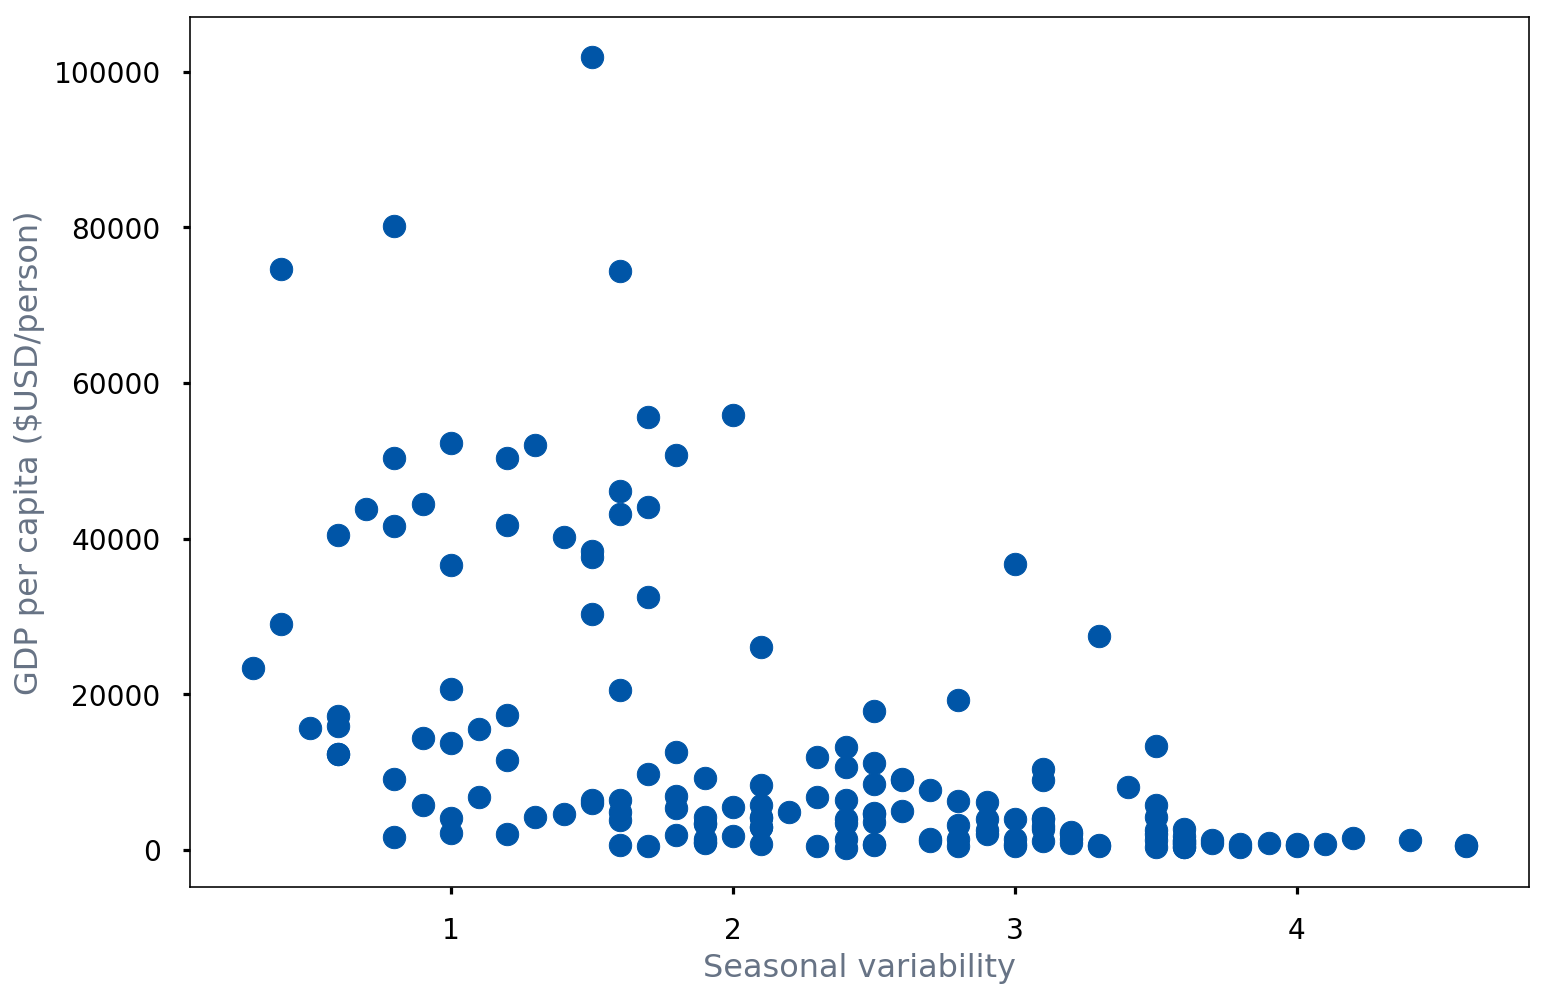

In [11]:
plt.scatter(recent.seasonal_variability, recent.gdp_per_capita)
plt.xlabel('Seasonal variability')
plt.ylabel('GDP per capita ($USD/person)')


In [12]:
def plot_scatter(df, x, y, xlabel=None, ylabel=None, title=None,
                 logx=False, logy=False, by=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(12, 10))

    colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']
    if by:
        groups = df.groupby(by)
        for j, (name, group) in enumerate(groups):
            ax.scatter(group[x], group[y], color=colors[j], label=name)
        ax.legend()
    else:
        ax.scatter(df[x], df[y], color=colors[0])
    if logx:
        ax.set_xscale('log')
    if logy:
        ax.set_yscale('log')

    ax.set_xlabel(xlabel if xlabel else x)
    ax.set_ylabel(ylabel if ylabel else y)
    if title:
        ax.set_title(title)
    return ax


In [13]:
svr = [recent.seasonal_variability.min(), recent.seasonal_variability.max()]
gdpr = [(recent.gdp_per_capita.min()), recent.gdp_per_capita.max()]
gdpbins = np.logspace(*np.log10(gdpr), 25)


D:\Coding\Anaconda3\envs\idata\lib\site-packages\numpy\lib\function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
D:\Coding\Anaconda3\envs\idata\lib\site-packages\numpy\lib\function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


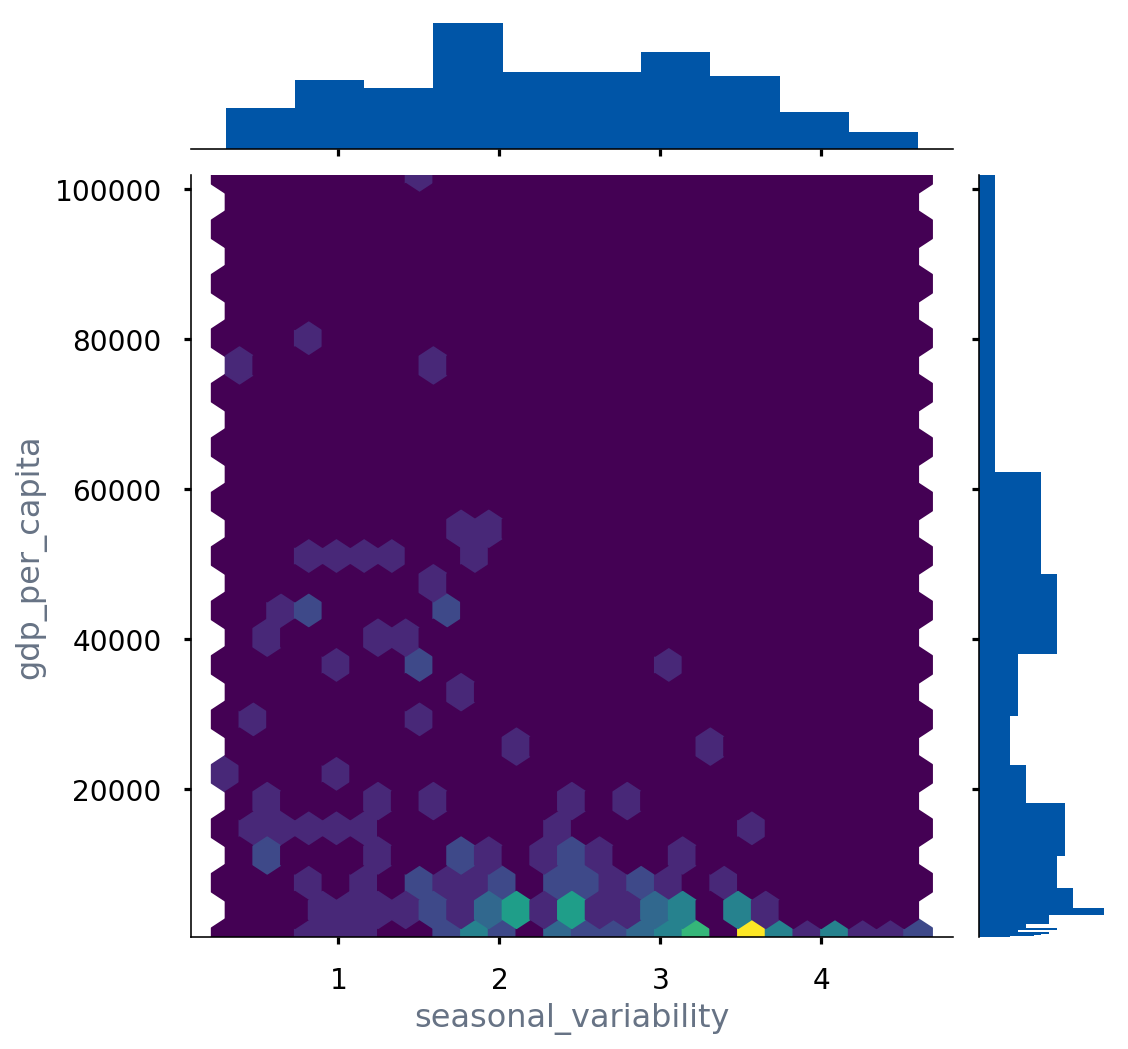

In [14]:
g = sns.JointGrid(x="seasonal_variability", y="gdp_per_capita", data=recent, ylim=gdpr)
g.ax_marg_x.hist(recent.seasonal_variability, range=svr)
g.ax_marg_y.hist(recent.gdp_per_capita, range=gdpr, bins=gdpbins, orientation="horizontal")
g.plot_joint(plt.hexbin, gridsize=25)
ax = g.ax_joint
# ax.set_yscale('log')
g.fig.set_figheight(8)
g.fig.set_figwidth(9)


In [15]:
recent_corr = recent.corr().loc['gdp_per_capita'].drop(['gdp', 'gdp_per_capita'])


In [17]:
def conditional_bar(series, bar_colors=None, color_labels=None, figsize=(13, 24),
                    xlabel=None, by=None, ylabel=None, title=None):
    fig, ax = plt.subplots(figsize=figsize)
    if not bar_colors:
        bar_colors = mpl.rcParams['axes.prop_cycle'].by_key()['color'][0]
    plt.barh(range(len(series)), series.values, color=bar_colors)
    plt.xlabel('' if not xlabel else xlabel);
    plt.ylabel('' if not ylabel else ylabel)
    plt.yticks(range(len(series)), series.index.tolist())
    plt.title('' if not title else title);
    plt.ylim([-1, len(series)]);
    if color_labels:
        for col, lab in color_labels.items():
            plt.plot([], linestyle='', marker='s', c=col, label=lab);
        lines, labels = ax.get_legend_handles_labels();
        ax.legend(lines[-len(color_labels.keys()):], labels[-len(color_labels.keys()):], loc='upper right');
    plt.close()
    return fig


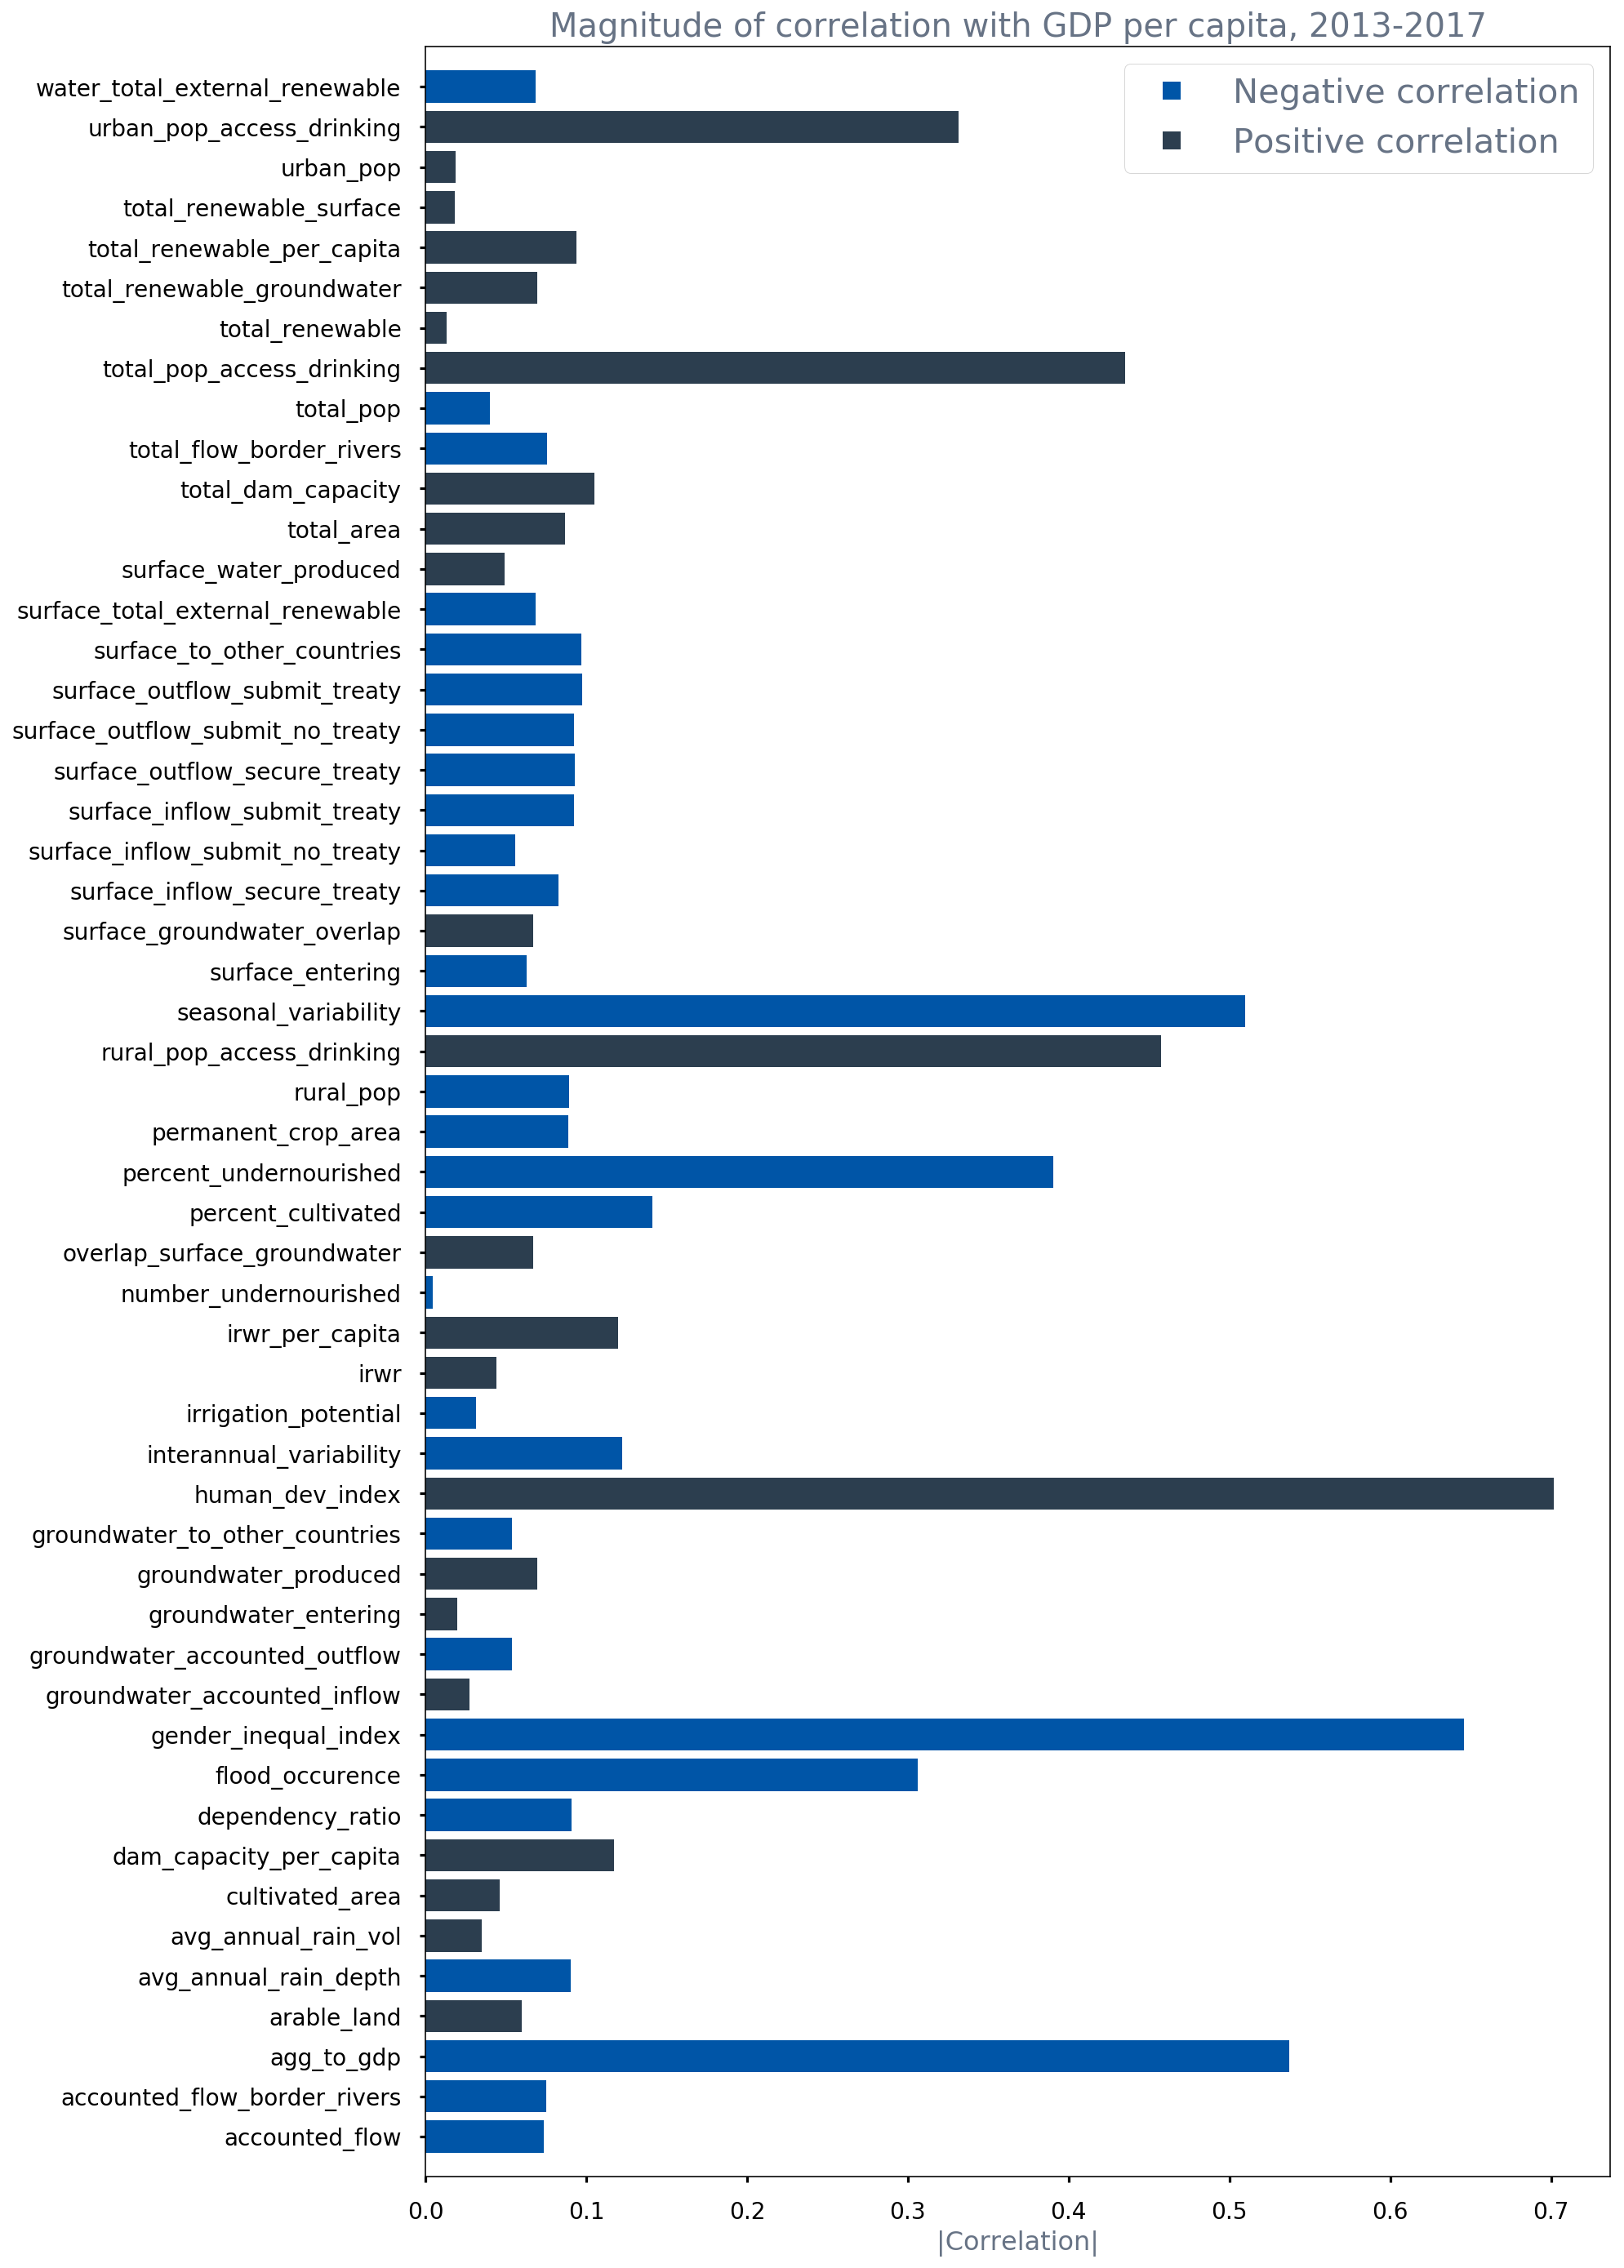

In [18]:
bar_colors = ['#0055A7' if x else '#2C3E4F' for x in list(recent_corr.values < 0)]
color_labels = {'#0055A7': 'Negative correlation', '#2C3E4F': 'Positive correlation'}

conditional_bar(recent_corr.apply(np.abs), bar_colors, color_labels,
                title='Magnitude of correlation with GDP per capita, 2013-2017',
                xlabel='|Correlation|')


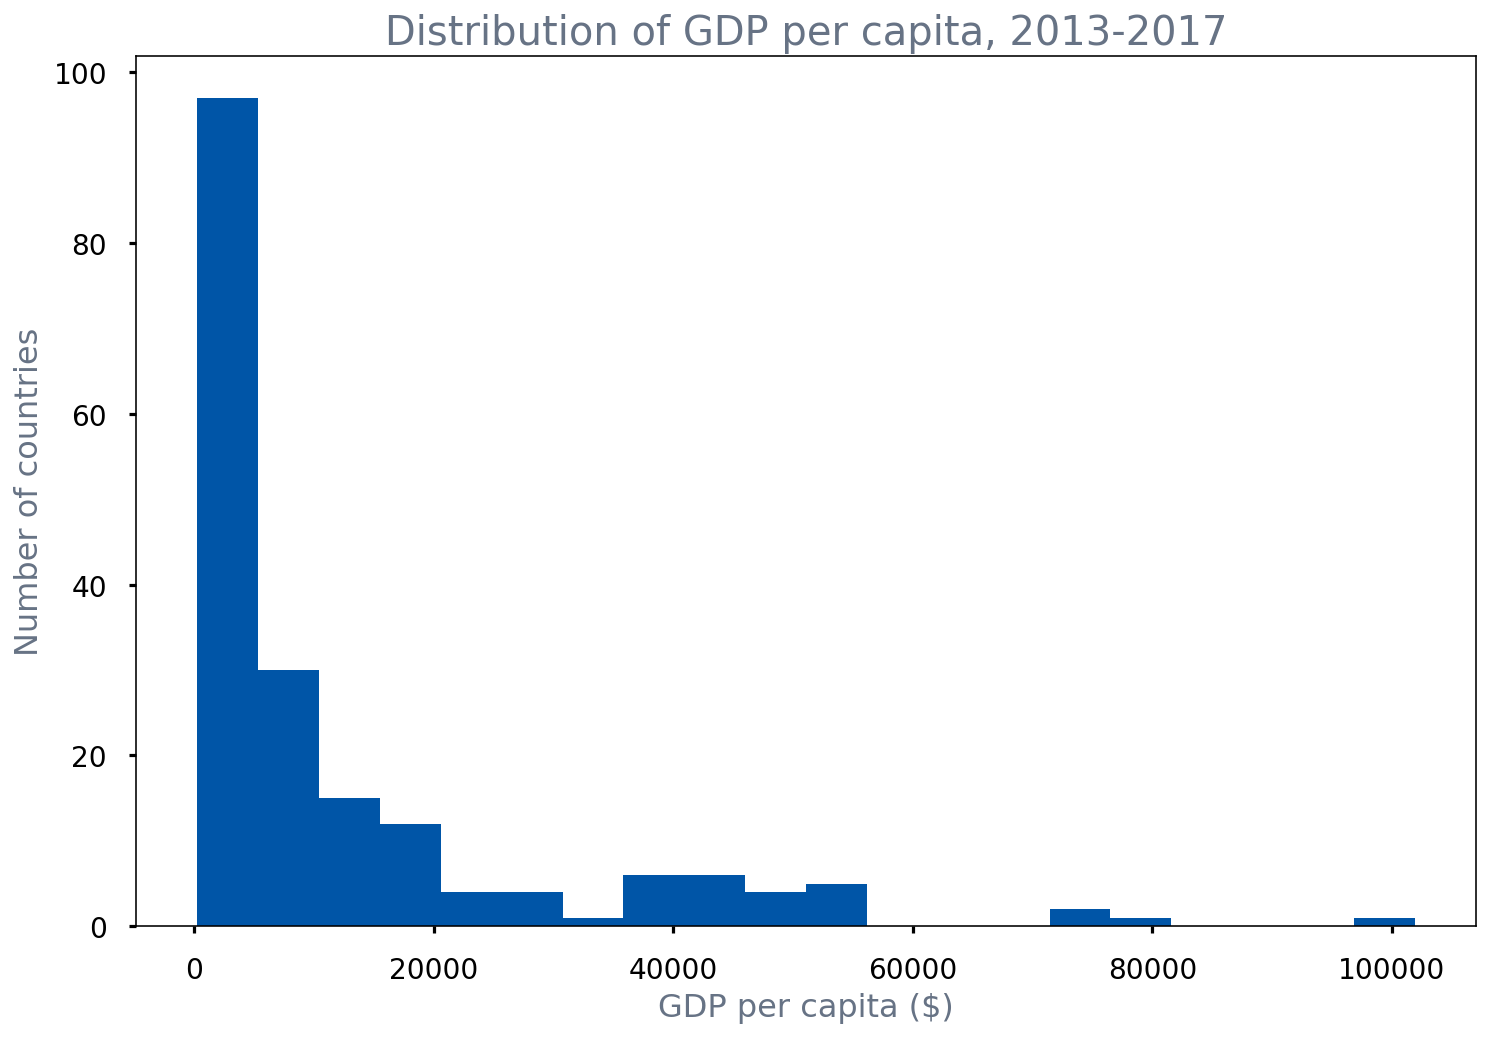

In [20]:
def plot_hist(df, variable, bins=20, xlabel=None, by=None,
              ylabel=None, title=None, logx=False, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(12, 8))
    if logx:
        if df[variable].min() <= 0:
            df[variable] = df[variable] - df[variable].min() + 1
            print('Warning: data <=0 exists, data transformed by %0.2g before plotting' % (- df[variable].min() + 1))

        bins = np.logspace(np.log10(df[variable].min()),
                           np.log10(df[variable].max()), bins)
        ax.set_xscale("log")

    ax.hist(df[variable].dropna().values, bins=bins);

    if xlabel:
        ax.set_xlabel(xlabel);
    if ylabel:
        ax.set_ylabel(ylabel);
    if title:
        ax.set_title(title);

    return ax


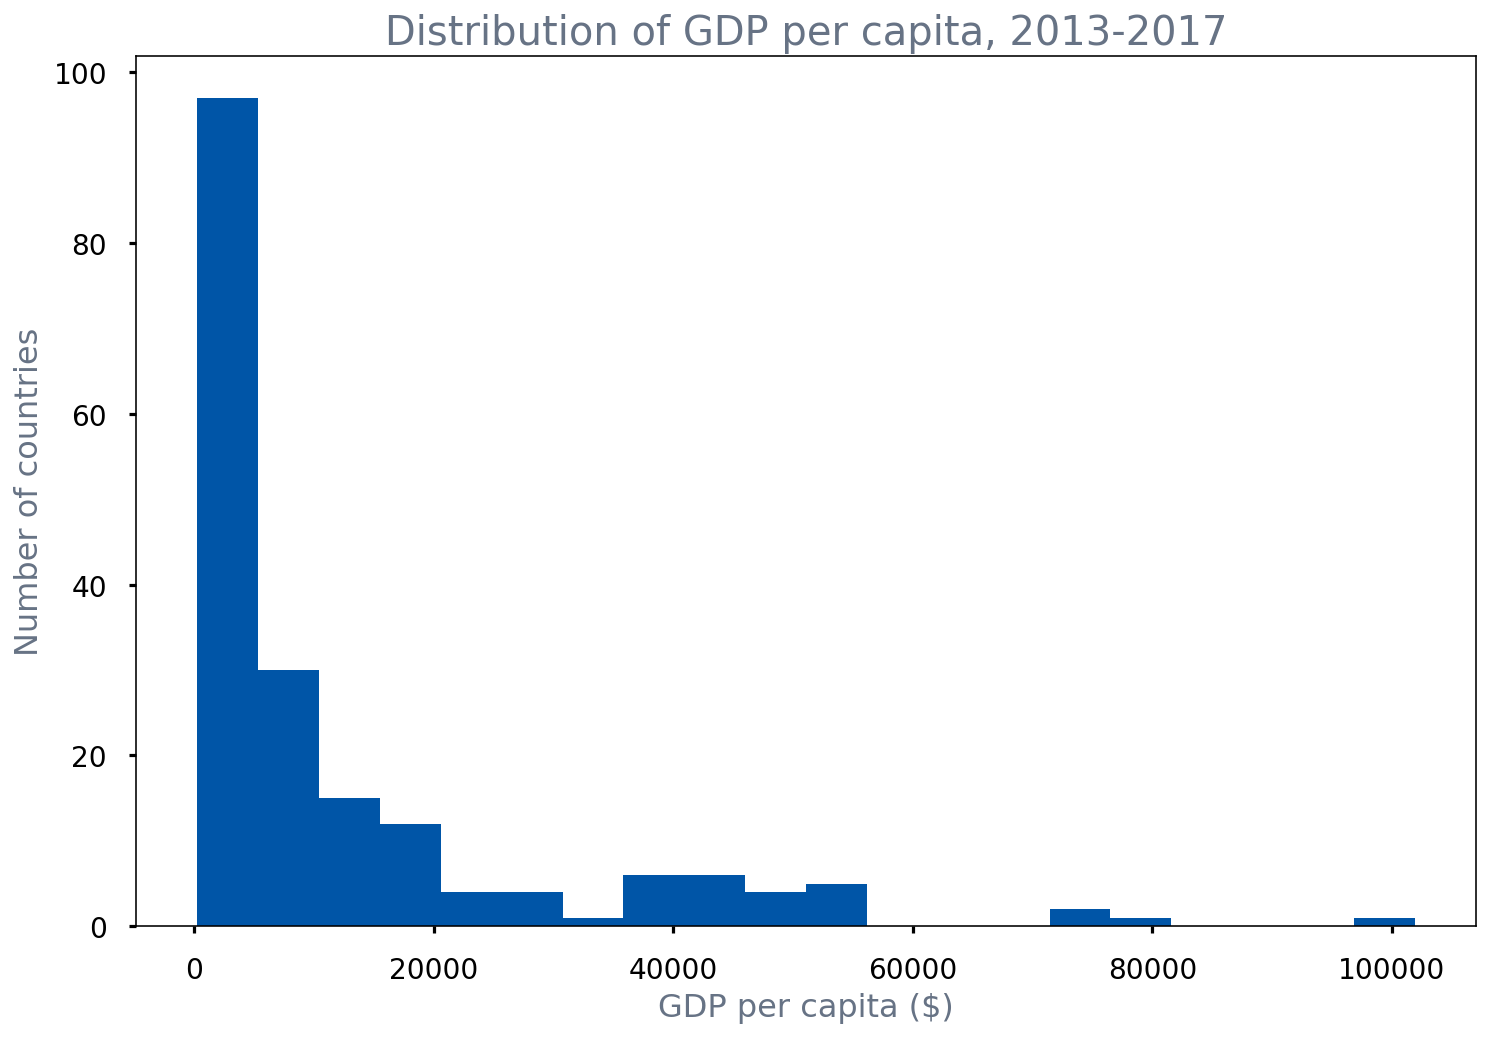

In [21]:
plot_hist(recent, 'gdp_per_capita', xlabel='GDP per capita ($)',
          ylabel='Number of countries',
          title='Distribution of GDP per capita, 2013-2017')


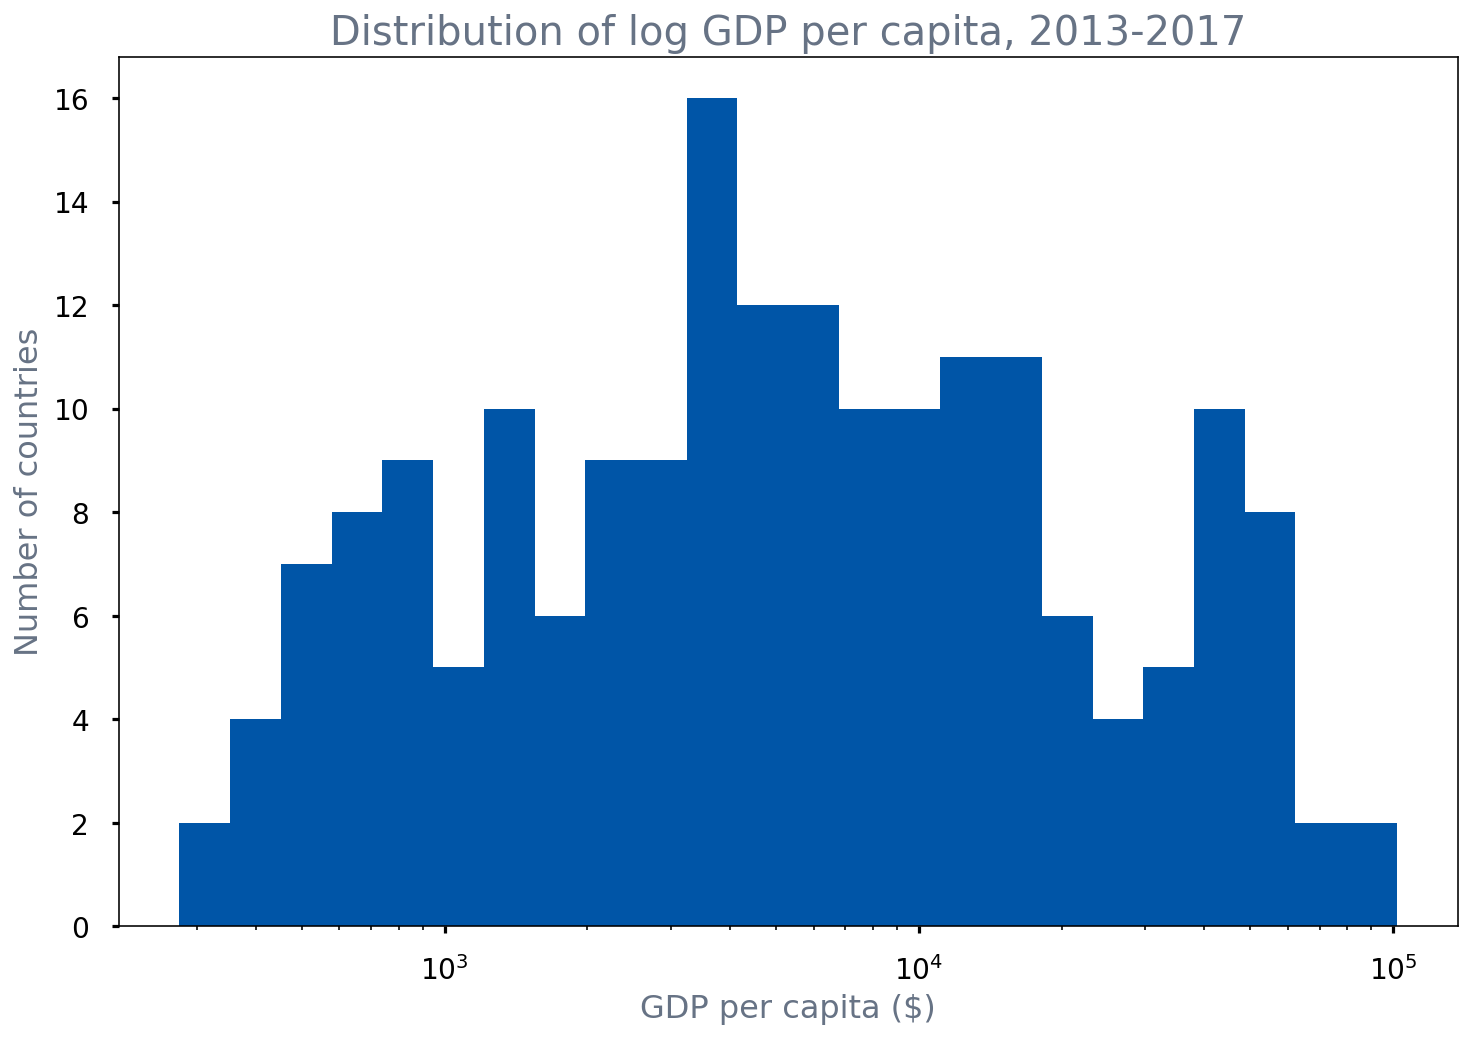

In [22]:
plot_hist(recent, 'gdp_per_capita', xlabel='GDP per capita ($)', logx=True,
          ylabel='Number of countries', bins=25,
          title='Distribution of log GDP per capita, 2013-2017')


In [23]:
capita_bins = ['Very low', 'Low', 'Medium', 'High', 'Very high']
recent['gdp_bin'] = pd.qcut(recent.gdp_per_capita, 5, capita_bins)
bin_ranges = pd.qcut(recent.gdp_per_capita, 5).unique()


In [24]:
def plot_hist(df, variable, bins=None, xlabel=None, by=None,
              ylabel=None, title=None, logx=False, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(12, 8))
    if logx:
        bins = np.logspace(np.log10(df[variable].min()),
                           np.log10(df[variable].max()), bins)
        ax.set_xscale("log")

    if by:
        if type(df[by].unique()) == pd.core.categorical.Categorical:
            cats = df[by].unique().categories.tolist()
        else:
            cats = df[by].unique().tolist()

        for cat in cats:
            to_plot = df[df[by] == cat][variable].dropna()
            ax.hist(to_plot, bins=bins);
    else:
        ax.hist(df[variable].dropna().values, bins=bins);

    if xlabel:
        ax.set_xlabel(xlabel);
    if ylabel:
        ax.set_ylabel(ylabel);
    if title:
        ax.set_title(title);

    return ax


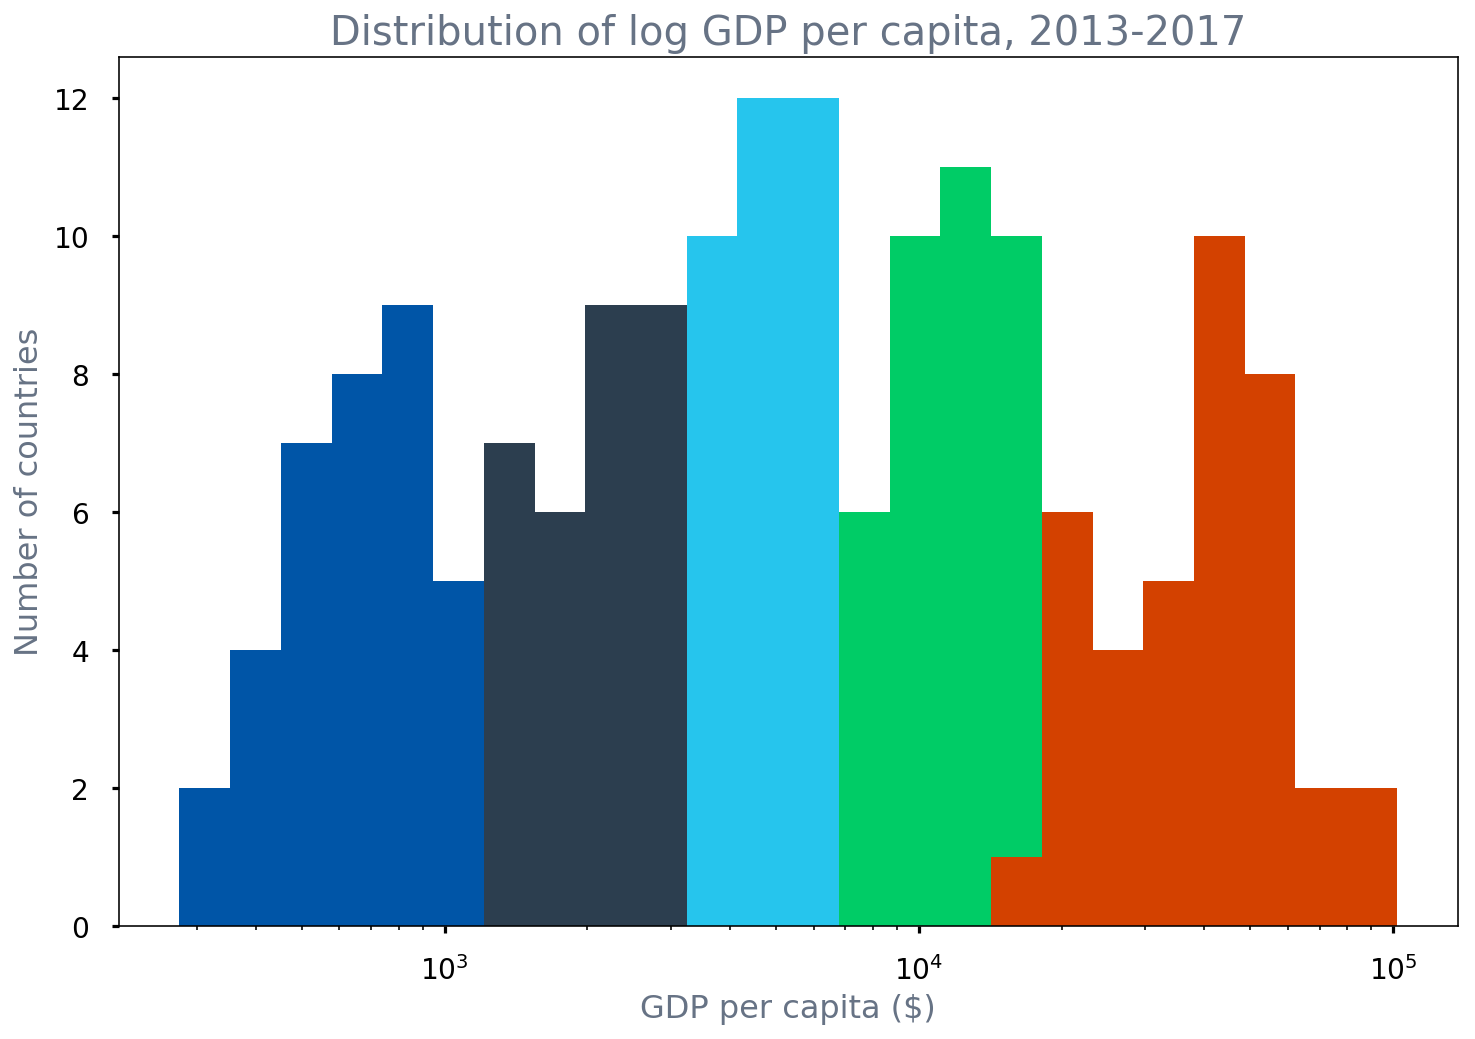

In [25]:
plot_hist(recent, 'gdp_per_capita', xlabel='GDP per capita ($)', logx=True,
          ylabel='Number of countries', bins=25, by='gdp_bin',
          title='Distribution of log GDP per capita, 2013-2017')


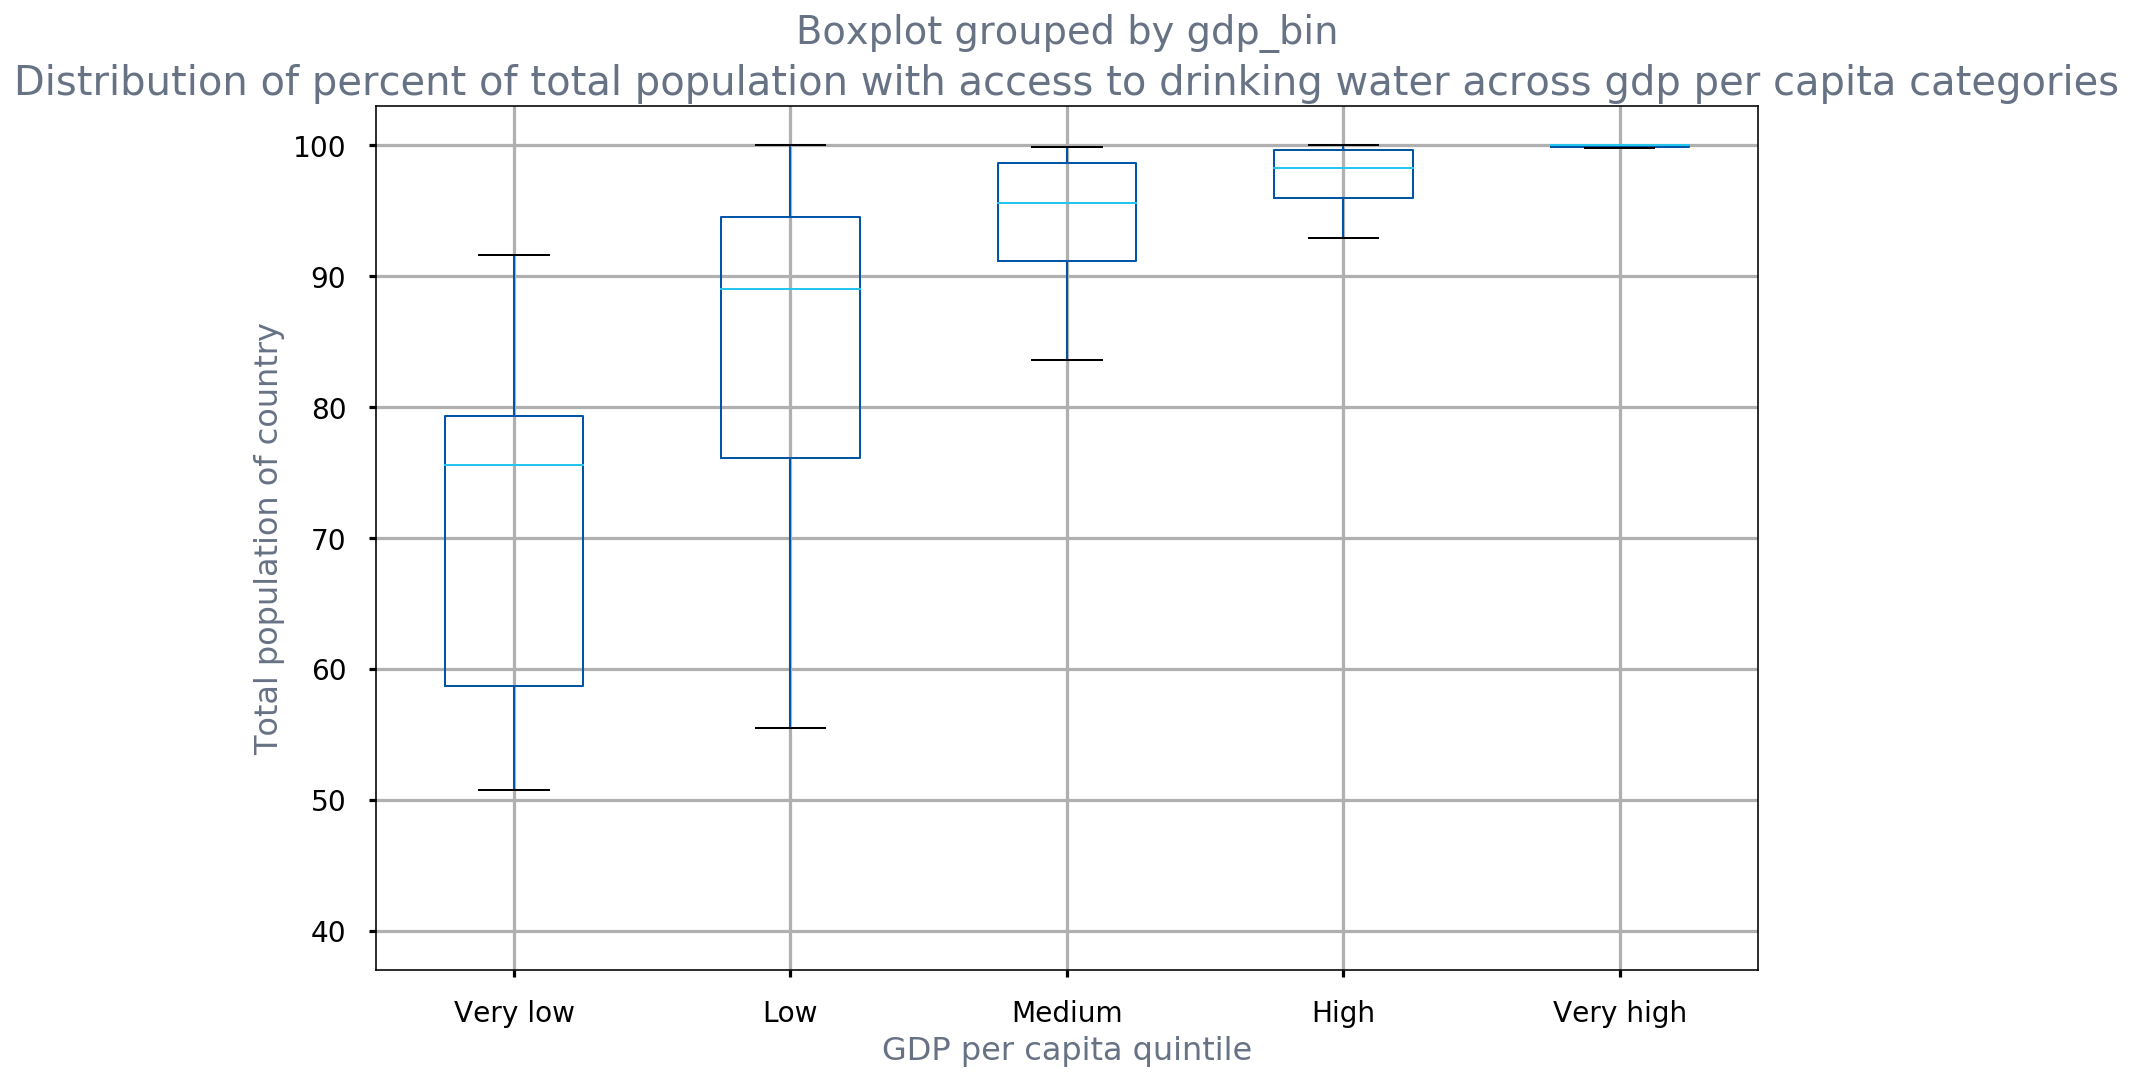

In [26]:
recent[['gdp_bin', 'total_pop_access_drinking']].boxplot(by='gdp_bin');
# plt.ylim([0,100000]);
plt.title('Distribution of percent of total population with access to drinking water across gdp per capita categories');
plt.xlabel('GDP per capita quintile');
plt.ylabel('Total population of country');


In [27]:
def mult_boxplots(df, variable, category,
                  xlabel=None, ylabel=None, title=None,
                  ylim=None):
    df[[variable, category]].boxplot(by=category);

    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)
    if ylim:
        plt.ylim(ylim)


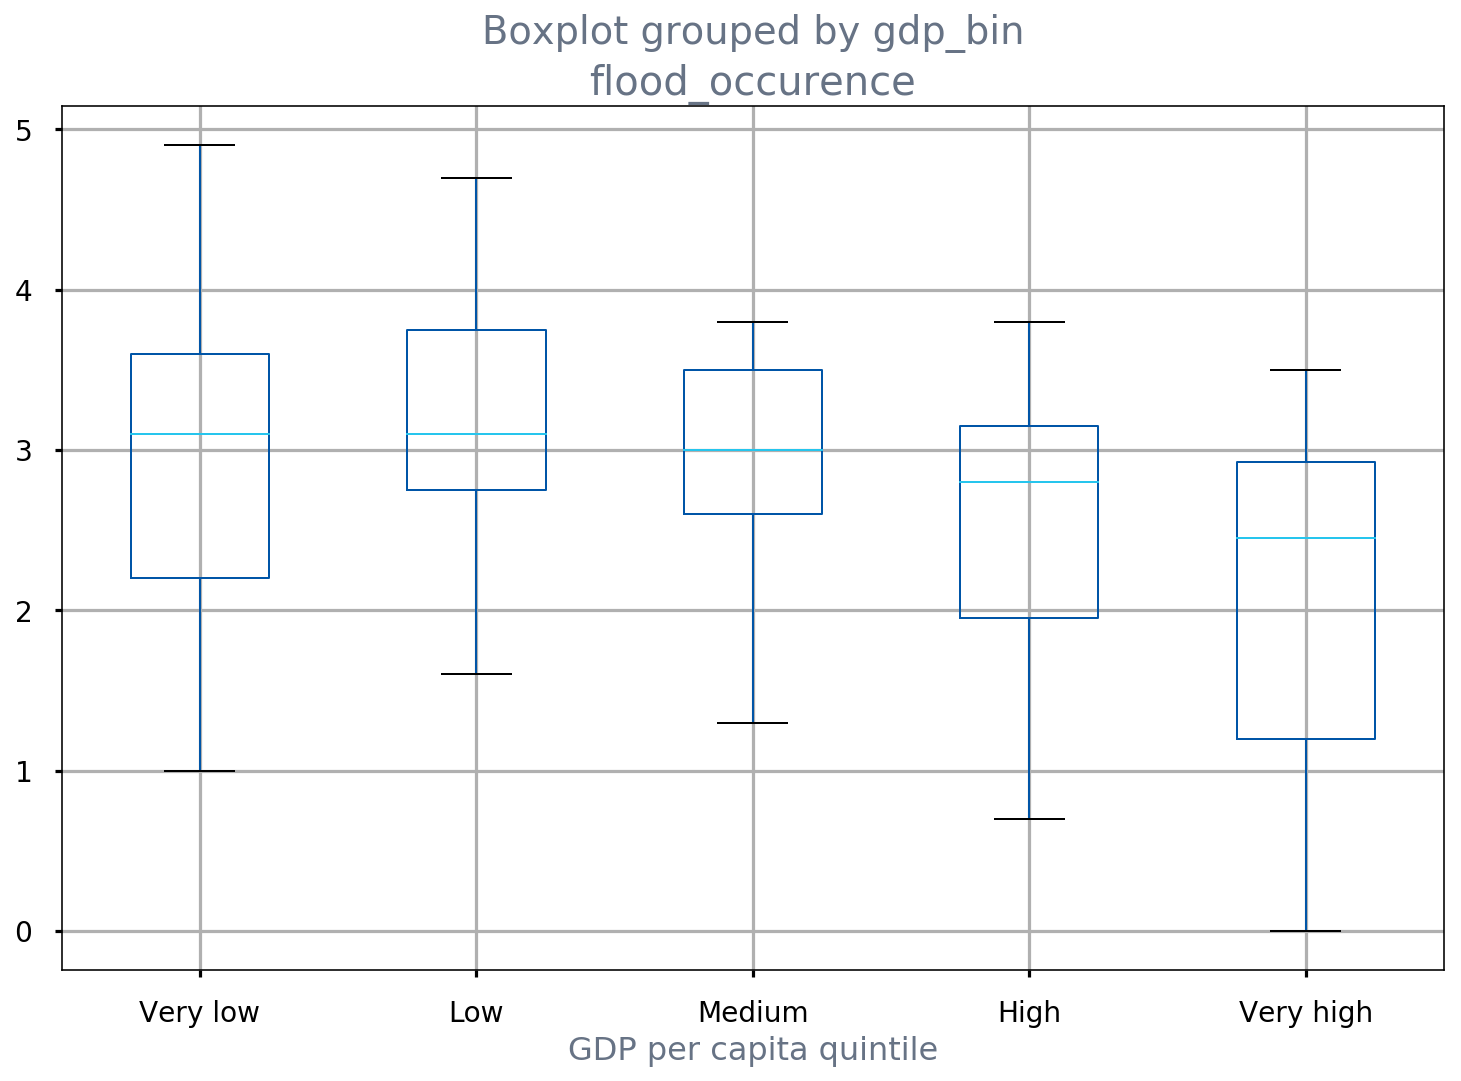

In [28]:
mult_boxplots(recent, 'flood_occurence', 'gdp_bin',
              xlabel='GDP per capita quintile')
